### Common Functions

In [441]:
from typing_extensions import Annotated
from joblib import dump, load
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import statsmodels.api as sm
from scipy import stats
from tqdm import tqdm
import anndata
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



def get_X(metadata, img_loc, pca_loc, add_intercept = True):
  loaded_pca = load(pca_loc)
  img_all = []
  with tqdm(range(metadata.shape[0]), desc = 'Loading data') as pbar:
    for i, record in metadata.iterrows():
      patient, replicate = record[['patient','replicate']]
      img_features = pd.read_csv(f'{img_loc}/{patient}_{replicate}_img_features.csv', index_col = [0,1,2])
      img_embedding = pd.DataFrame(loaded_pca.transform(img_features),
                                   index = img_features.index,
                                   columns = [f'img_feature_{j}' for j in range(loaded_pca.n_components)]
                                   ) # no fitting
      img_all.append(img_embedding)
      pbar.update(1)
  features = pd.concat([pd.concat(img_all)],axis = 1)
  if add_intercept:
    features.insert(0, 'bias', 1)
  return features

def get_y(metadata, top_genes_loc):
  top_genes = pd.read_csv(top_genes_loc, header = None)[0].tolist()
  # Create target dataset
  y = []
  with tqdm(range(metadata.shape[0]), desc = 'Loading y-labels') as pbar:
    for i, record in metadata.iterrows():
      type_i, patient, replicate = record['type'], record['patient'], record['replicate']
      # df_expression = pd.read_csv(f'bucket/stdata/{patient}_{replicate}_stdata.tsv.gz', sep='\t', index_col=0, compression='gzip')[top_genes]
      # # Read the .tsv.gz file directly from GCS bucket into a pandas DataFrame
      # df_coordinates = pd.read_csv(f'bucket/spots/{record["spot_coordinates"]}', sep=',', index_col=0, compression='gzip')

      adata = anndata.read_h5ad(f'bucket/anndata/{patient}_{replicate}.h5ad')
      df_expression = pd.DataFrame(adata.X, columns = adata.var_names, index = adata.obs_names)[top_genes]
      df_coordinates = pd.DataFrame(adata.obsm["spatial"], columns = ["X", "Y"], index = adata.obs_names)
      df_distances =  pd.DataFrame(adata.obsp["distances"].todense(), index = adata.obs_names, columns = adata.obs_names)

      # Filter DataFrames to include only common labels
      common_labels = df_expression.index.intersection(df_coordinates.index)
      # final gene_expressison
      gene_expression = df_expression.loc[common_labels, :].to_numpy()
      y.append(gene_expression)
      pbar.update()
  return np.concatenate(y)


def get_X_y(metadata, img_loc, pca_loc, top_genes_loc):

  # for obtaining y
  top_genes = pd.read_csv(top_genes_loc, header=None)[0].tolist()

  loaded_pca = load(pca_loc)
  img_all = []
  exp_data = []
  edge_list = []

  with tqdm(range(metadata.shape[0]), desc = 'Loading data') as pbar:
      for i, record in metadata.iterrows():
          patient, replicate = record[['patient', 'replicate']]

          # create the features from image and adjacency dataframes
          img_features = pd.read_csv(f'{img_loc}/{patient}_{replicate}_img_features.csv', index_col=[0, 1, 2])
          img_embedding = pd.DataFrame(loaded_pca.transform(img_features),
                                        index=img_features.index,
                                        columns=[f'img_feature_{j}' for j in range(loaded_pca.n_components)]
                                        )  # no fitting
          img_all.append(img_embedding)

          # Now create the gene expression dataframe with spot information
          # Load gene expression data
          # df_expression = pd.read_csv(f'bucket/stdata/{patient}_{replicate}_stdata.tsv.gz', sep='\t', index_col=0, compression='gzip')[top_genes]
          # df_coordinates = pd.read_csv(f'bucket/spots/{record["spot_coordinates"]}', sep=',', index_col=0, compression='gzip')

          adata = anndata.read_h5ad(f'bucket/anndata/{patient}_{replicate}.h5ad')
          df_expression = pd.DataFrame(adata.X, columns = adata.var_names, index = adata.obs_names)[top_genes]
          df_coordinates = pd.DataFrame(adata.obsm["spatial"], columns = ["X", "Y"], index = adata.obs_names)

          # Find common labels (spot IDs)
          common_labels = df_expression.index.intersection(df_coordinates.index)
          # Adjusted to ensure indexing consistency
          # The trick here is to ensure df_expression is correctly indexed before appending
          df_expression_filtered = df_expression.loc[common_labels]
          df_expression_filtered = (df_expression_filtered
                                    .assign(Patient=patient, Replicate=replicate)
                                    .set_index(['Patient', 'Replicate'],
                                                append=True)
                                      .reorder_levels(['Patient', 'Replicate', df_expression_filtered.index.name]))

          exp_data.append(df_expression_filtered)


          df_distances =  pd.DataFrame(adata.obsp["distances"].todense(), index = adata.obs_names, columns = adata.obs_names).loc[common_labels]
          # creating edge list between spots
          target = []
          source = []

          # Iterate over the DataFrame
          for i in range(len(df_distances)):
              for j in range(i + 1, len(df_distances.columns)):  # i + 1 to ensure we're looking at the upper triangle
                  if df_distances.iloc[i, j] != 0 and df_distances.iloc[j, i] != 0:
                      target.append(df_distances.index[i])
                      source.append(df_distances.columns[j])

          # edges now contains the edge list
          df_edges = (pd.DataFrame({'target': target,
                                   'source': source}).assign(Patient=patient, Replicate=replicate)
                                    .set_index(['Patient', 'Replicate'],
                                                append=True))


          edge_list.append(df_edges)

          pbar.update(1)


  features = pd.concat([pd.concat(img_all)], axis=1)
  edges = pd.concat([pd.concat(edge_list)], axis=1)

  y = pd.concat(exp_data)

  return features, y, edges

def pearson_correlation(y_true, y_pred):
    return stats.pearsonr(y_true, y_pred)[0]

def spearman_correlation(y_true, y_pred):
    return stats.spearmanr(y_true, y_pred)[0]

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r_squared(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)



# Assuming y_true and y_pred are the DataFrames with true and predicted gene expression data
def get_performance(y_true, y_pred):
  metrics = []
  with tqdm(range(len(y_true.columns)), 'Assessing model performance by gene') as pbar:
    for gene in y_true.columns:
        y_true_gene = y_true[gene]
        y_pred_gene = y_pred[gene]

        pcc = pearson_correlation(y_true_gene, y_pred_gene)
        srcc = spearman_correlation(y_true_gene, y_pred_gene)
        mse = mean_squared_error(y_true_gene, y_pred_gene)
        mae = mean_absolute_error(y_true_gene, y_pred_gene)
        r2 = r_squared(y_true_gene, y_pred_gene)

        metrics.append([gene, pcc, srcc, mse, mae, r2])
        pbar.update()

  # performance by gene
  metrics_df = pd.DataFrame(metrics, columns=['Gene', 'PCC', 'SRCC', 'MSE', 'MAE', 'R2']).set_index('Gene')
  overall_metrics_df = metrics_df.mean()
  return metrics_df, overall_metrics_df


# Save models
def save_models(train_y, train_pred, valid_y, valid_pred, models, run_name, sub_run_name):
  if not os.path.exists(f'bucket/models/{run_name}/{sub_run_name}/predictions'):
    os.makedirs(f'bucket/models/{run_name}/{sub_run_name}/predictions')
  if not os.path.exists(f'bucket/models/{run_name}/{sub_run_name}/gene_models'):
    os.makedirs(f'bucket/models/{run_name}/{sub_run_name}/gene_models')
  for i, gene in enumerate(models):
    models[gene].save(f'bucket/models/{run_name}/{sub_run_name}/gene_models/gene_{gene}_nb.pickle')
  # Save predictions and truth
  train_y.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/train_y.csv')
  train_pred.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/train_predictions.csv')
  valid_y.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/valid_y.csv')
  valid_pred.to_csv(f'bucket/models/{run_name}/{sub_run_name}/predictions/valid_predictions.csv')
  print('Saved models and predictions')

# Modeling

## Graph Neural Network with embedding inputs

In [442]:
import pandas as pd

train_metadata = pd.read_csv('bucket/train_metadata.csv', index_col = 0)
valid_metadata = pd.read_csv('bucket/valid_metadata.csv', index_col = 0)
#test_metadata = pd.read_csv('bucket/test_metadata.csv', index_col = 0)


In [443]:
run_name = 'gnn_linear'
img_loc = f'bucket/datasets/knn_pooling/preprocessed_img' # not pooled
pca_loc = f'bucket/models/simple_baseline/image_pca_resnet_32.joblib' # not pooled
top_genes_loc = f'bucket/top_250_genes_new.txt'


In [444]:
train_X, train_y_full, train_edge_list = get_X_y(train_metadata, img_loc, pca_loc, top_genes_loc)
valid_X, valid_y_full, valid_edge_list = get_X_y(valid_metadata, img_loc, pca_loc, top_genes_loc)


Loading data: 100%|██████████| 15/15 [00:48<00:00,  3.22s/it]


In [445]:
train_X_ = train_X.reset_index()
train_X_.insert(0, 'node_id',  train_X_["Patient"] + "_" + train_X_["Replicate"] + "_" + train_X_["Index"])
train_X_.drop(columns=["Patient", "Replicate",	"Index"], inplace=True)

In [446]:
valid_X_ = valid_X.reset_index()
valid_X_.insert(0, 'node_id',  valid_X_["Patient"] + "_" + valid_X_["Replicate"] + "_" + valid_X_["Index"])
valid_X_.drop(columns=["Patient", "Replicate",	"Index"], inplace =True)

In [447]:
train_edge_list_ = train_edge_list.reset_index()
train_edge_list_["target"] = train_edge_list_["Patient"] + "_" + train_edge_list_["Replicate"] + "_" + train_edge_list_["target"]
train_edge_list_["source"] = train_edge_list_["Patient"] + "_" + train_edge_list_["Replicate"] + "_" + train_edge_list_["source"]
train_edge_list_.drop(columns=["Patient", "Replicate", "level_0"], inplace=True)

In [448]:
valid_edge_list_ = valid_edge_list.reset_index()
valid_edge_list_["target"] = valid_edge_list_["Patient"] + "_" + valid_edge_list_["Replicate"] + "_" + valid_edge_list_["target"]
valid_edge_list_["source"] = valid_edge_list_["Patient"] + "_" + valid_edge_list_["Replicate"] + "_" + valid_edge_list_["source"]
valid_edge_list_.drop(columns=["Patient", "Replicate", "level_0"], inplace=True)

In [449]:
train_y_full_ = train_y_full.reset_index()
train_y_full_.insert(0, 'node_id',  train_y_full_["Patient"] + "_" + train_y_full_["Replicate"] + "_" + train_y_full_["level_2"])
train_y_full_.drop(columns=["Patient", "Replicate",	"level_2"], inplace=True)

In [450]:
valid_y_full_ = valid_y_full.reset_index()
valid_y_full_.insert(0, 'node_id',  valid_y_full_["Patient"] + "_" + valid_y_full_["Replicate"] + "_" + valid_y_full_["level_2"])
valid_y_full_.drop(columns=["Patient", "Replicate",	"level_2"], inplace=True)

In [451]:
train_mapper = {node: i for i, node in enumerate(train_X_.node_id)}
valid_mapper = {node: i for i, node in enumerate(valid_X_.node_id)}

In [452]:
train_X_["node_id"] = train_X_["node_id"].apply(lambda x: train_mapper[x])
valid_X_["node_id"] = valid_X_["node_id"].apply(lambda x: valid_mapper[x])

In [453]:
train_edge_list_["source"] = train_edge_list_["source"].apply(lambda x: train_mapper[x])
valid_edge_list_["source"] = valid_edge_list_["source"].apply(lambda x: valid_mapper[x])


train_edge_list_["target"] = train_edge_list_["target"].apply(lambda x: train_mapper[x])
valid_edge_list_["target"] = valid_edge_list_["target"].apply(lambda x: valid_mapper[x])

In [454]:
train_y_full_["node_id"] = train_y_full_["node_id"].apply(lambda x: train_mapper[x])
valid_y_full_["node_id"] = valid_y_full_["node_id"].apply(lambda x: valid_mapper[x])



### Keras GNN

In [457]:
input_size = train_X_.shape[1]
output_size = train_y_full_.shape[1]

num_features = input_size
num_outputs = output_size


In [458]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = train_edge_list_[["source", "target"]].to_numpy().T

# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (tf.convert_to_tensor(train_X_), edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", train_X_.shape)

Edges shape: (2, 22982)
Nodes shape: (17682, 33)


In [459]:
def create_gru(hidden_units, dropout_rate):
    inputs = keras.layers.Input(shape=(2, hidden_units[0]))
    x = inputs
    for units in hidden_units:
      x = layers.GRU(
          units=units,
          activation="tanh",
          recurrent_activation="sigmoid",
          return_sequences=True,
          dropout=dropout_rate,
          return_state=False,
          recurrent_dropout=dropout_rate,
      )(x)
    return keras.Model(inputs=inputs, outputs=x)


class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gru":
            self.update_fn = create_gru(hidden_units, dropout_rate)
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [460]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [461]:
class GNNNodeRegressor(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        output_units,  # number of output units for regression
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.8,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_output = layers.Dense(units=output_units, name="output", activation=None)

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_output(node_embeddings)

In [518]:
hidden_units = [32, 32]
learning_rate = 0.001
dropout_rate = 0.8
num_epochs = 100
batch_size = 128

In [519]:
gnn_model = GNNNodeRegressor(
    graph_info=graph_info,
    output_units=250,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1,10,100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 3.77984345e-01 -6.03262186e-01 -4.60705251e-01  3.86956304e-01
  -2.68135935e-01 -1.72422886e+00  9.36414003e-02  1.29915267e-01
  -6.32949233e-01 -1.56772956e-01 -9.99862790e-01 -1.15819490e+00
  -4.72315490e-01  3.41053069e-01 -5.65335333e-01 -1.00437987e+00
   3.35680008e-01  1.77866042e-01 -4.58042026e-01  7.17113137e-01
   5.48442006e-01  1.08734989e+00  9.08104777e-01 -5.39697528e-01
  -5.12466371e-01  3.41345280e-01  4.89879847e-01  8.66778940e-02
   2.72275686e-01  5.30930758e-02  4.42206323e-01 -4.04167771e-02
   8.04969251e-01 -2.48592317e-01  9.57293630e-01  1.44473481e+00
  -1.33850545e-01  3.59915346e-01 -1.01179469e+00  8.97127628e-01
  -2.98182428e-01 -6.36141658e-01 -1.40516311e-01  1.09850085e+00
   3.92295361e-01  1.33395696e+00  8.44535708e-01  1.14629459e+00
  -5.92320561e-02  9.48112607e-01 -4.06189650e-01  3.23157251e-01
  -1.37866020e-01  3.02757531e-01 -3.70349646e-01 -3.27993751e-01
   1.17295265e-01 -1.39300287e-01  7.15572178e-

Train

In [520]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Nadam(learning_rate),
        loss=tf.keras.losses.MeanSquaredError(
    reduction="sum_over_batch_size", name="mean_squared_error"),
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_rmse", patience=15, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping],
    )

    return history

In [521]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["rmse"])
    ax2.plot(history.history["val_rmse"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("RMSE")
    plt.show()

In [522]:
x_train = train_X_.node_id.to_numpy()
y_train = train_y_full_.drop(columns=["node_id"]).to_numpy()

In [523]:
x_val = valid_X_.node_id.to_numpy()
y_val = valid_y_full_.drop(columns=["node_id"]).to_numpy()

In [524]:
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/100
139/139 [==============================] - 26s 103ms/step - loss: 0.5712 - rmse: 0.7558 - val_loss: 0.4446 - val_rmse: 0.6668
Epoch 2/100
139/139 [==============================] - 14s 98ms/step - loss: 0.3186 - rmse: 0.5645 - val_loss: 0.3355 - val_rmse: 0.5792
Epoch 3/100
139/139 [==============================] - 14s 98ms/step - loss: 0.2823 - rmse: 0.5313 - val_loss: 0.3226 - val_rmse: 0.5680
Epoch 4/100
139/139 [==============================] - 14s 98ms/step - loss: 0.2663 - rmse: 0.5160 - val_loss: 0.3221 - val_rmse: 0.5676
Epoch 5/100
139/139 [==============================] - 14s 98ms/step - loss: 0.2585 - rmse: 0.5085 - val_loss: 0.3177 - val_rmse: 0.5636
Epoch 6/100
139/139 [==============================] - 14s 98ms/step - loss: 0.2514 - rmse: 0.5014 - val_loss: 0.3211 - val_rmse: 0.5667
Epoch 7/100
139/139 [==============================] - 14s 98ms/step - loss: 0.2481 - rmse: 0.4981 - val_loss: 0.3165 - val_rmse: 0.5626
Epoch 8/100
139/139 [===================

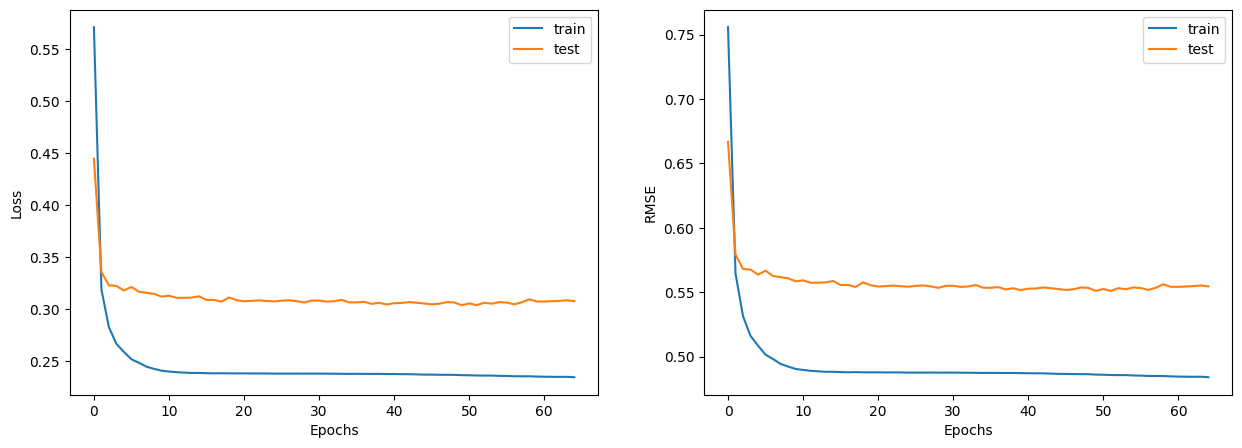

In [525]:
display_learning_curves(history)

In [526]:
train_rev_mapper = {v:k for k,v in train_mapper.items()}
valid_rev_mapper = {v:k for k,v in valid_mapper.items()}

In [573]:
train_predictions_df = pd.DataFrame(gnn_model.predict(x_train),
                                    index = train_X_['node_id'].apply(lambda x: train_rev_mapper[x]),
                                    columns = train_y_full_.columns[1:])
valid_predictions_df = pd.DataFrame(gnn_model.predict(x_val),
                                    index = valid_X_['node_id'].apply(lambda x: valid_rev_mapper[x]),
                                    columns = valid_y_full_.columns[1:])

215/215 [==============================] - 4s 19ms/step


In [574]:
train_y_full__ = train_y_full_.copy()
train_y_full__['node_id'] = train_y_full__['node_id'].apply(lambda x: train_rev_mapper[x])
train_y_full__.set_index('node_id', inplace=True)


valid_y_full__ = valid_y_full_.copy()
valid_y_full__['node_id'] = valid_y_full__['node_id'].apply(lambda x: valid_rev_mapper[x])
valid_y_full__.set_index('node_id', inplace=True)

In [530]:
train_metrics_gene, train_metrics_overall = get_performance(train_y_full__, train_predictions_df)
valid_metrics_gene, valid_metrics_overall = get_performance(valid_y_full__, valid_predictions_df)
display(train_metrics_gene, train_metrics_overall)
display(valid_metrics_gene, valid_metrics_overall)

Assessing model performance by gene: 100%|██████████| 250/250 [00:01<00:00, 165.90it/s]


,PCC,SRCC,MSE,MAE,R2
Gene,,,,,
ENSG00000171345,0.064620,0.244957,1.196509,0.873968,-0.002251
ENSG00000149273,0.395132,0.303212,0.468937,0.520521,0.013600
ENSG00000204628,0.356352,0.463599,0.558962,0.592166,0.015091
ENSG00000117984,0.391961,0.301008,0.794262,0.723627,0.007924
ENSG00000108518,0.446781,0.441349,0.555629,0.586456,0.015301
...,...,...,...,...,...
ENSG00000146576,0.097936,0.116737,0.082158,0.186026,0.001150
ENSG00000187713,0.106917,0.114148,0.072976,0.194222,-0.003714
ENSG00000104140,0.051938,0.031538,0.035468,0.096275,-0.001537


PCC     0.142968
SRCC    0.174713
MSE     0.236293
MAE     0.343285
R2      0.001371
dtype: float64

,PCC,SRCC,MSE,MAE,R2
Gene,,,,,
ENSG00000171345,0.114479,0.301987,1.192767,0.923825,-0.028184
ENSG00000149273,-0.392702,-0.180159,1.030686,0.861618,-0.690286
ENSG00000204628,0.075608,0.125828,0.386042,0.491865,-0.126423
ENSG00000117984,0.001738,-0.062468,0.798367,0.714466,-0.208886
ENSG00000108518,-0.054158,-0.085423,0.429258,0.508367,-0.050371
...,...,...,...,...,...
ENSG00000146576,0.021362,0.032818,0.129320,0.231212,-0.026309
ENSG00000187713,-0.033341,-0.034274,0.093898,0.215438,-0.002127
ENSG00000104140,0.178967,0.059320,0.313106,0.333164,-0.271336


PCC    -0.026023
SRCC   -0.017037
MSE     0.303559
MAE     0.389752
R2     -0.087611
dtype: float64

Hyperparameter optimization

In [401]:
import itertools


hidden_units_options = [[64, 64], [32, 32], [64, 32]]
dropout_rate_options = [0.2, 0.5, 0.8]
learning_rate_options = [0.001, 0.0001, 0.01]
optimizer_options = ['adam', 'nadam', 'sgd', 'rmsprop']


def compile_model(optimizer_name, learning_rate):
    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'nadam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model = GNNNodeRegressor(
        graph_info=graph_info,
        output_units=250,
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        name="gnn_model",
    )
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.LogCosh(reduction="sum_over_batch_size", name="log_cosh"),
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
    )
    return model

# Function to run an experiment with the given hyperparameters
def run_experiment(hidden_units, dropout_rate, learning_rate, optimizer_name):
    model = compile_model(optimizer_name, learning_rate)
    history = model.fit(
        x_train, y_train,  # Assuming 'x_train' and 'y_train' are your training data
        validation_data=(x_val, y_val),  # Assuming 'x_val' and 'y_val' are your validation data
        epochs=num_epochs,  # Assuming 'num_epochs' is defined
        batch_size=batch_size,  # Assuming 'batch_size' is defined
        verbose=0  # Set verbose to 0 for less output during training
    )
    val_rmse = history.history['val_rmse'][-1]
    return val_rmse

# Iterate over all combinations of hyperparameters
results = []
for hidden_units, dropout_rate, learning_rate, optimizer in itertools.product(
        hidden_units_options, dropout_rate_options, learning_rate_options, optimizer_options):

    print(f"Training with: hidden_units={hidden_units}, dropout_rate={dropout_rate}, "
          f"learning_rate={learning_rate}, optimizer={optimizer}")

    val_rmse = run_experiment(hidden_units, dropout_rate, learning_rate, optimizer)

    results.append({
        'hidden_units': hidden_units,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'optimizer': optimizer,
        'val_rmse': val_rmse
    })

# Sort results by validation RMSE
results.sort(key=lambda x: x['val_rmse'])

# Save or print the results
with open('hyperparameter_tuning_results.txt', 'w') as f:
    for result in results:
        f.write(f"{result}\n")

print("Hyperparameter tuning is complete. Check 'hyperparameter_tuning_results.txt' for the results.")


Training with: hidden_units=[64, 64], dropout_rate=0.2, learning_rate=0.001, optimizer=adam
Training with: hidden_units=[64, 64], dropout_rate=0.2, learning_rate=0.001, optimizer=sgd
Training with: hidden_units=[64, 64], dropout_rate=0.2, learning_rate=0.001, optimizer=rmsprop
Training with: hidden_units=[64, 64], dropout_rate=0.2, learning_rate=0.0001, optimizer=adam
Training with: hidden_units=[64, 64], dropout_rate=0.2, learning_rate=0.0001, optimizer=sgd
Training with: hidden_units=[64, 64], dropout_rate=0.2, learning_rate=0.0001, optimizer=rmsprop
Training with: hidden_units=[64, 64], dropout_rate=0.2, learning_rate=0.01, optimizer=adam
Training with: hidden_units=[64, 64], dropout_rate=0.2, learning_rate=0.01, optimizer=sgd
Training with: hidden_units=[64, 64], dropout_rate=0.2, learning_rate=0.01, optimizer=rmsprop
Training with: hidden_units=[64, 64], dropout_rate=0.5, learning_rate=0.001, optimizer=adam
Training with: hidden_units=[64, 64], dropout_rate=0.5, learning_rate=0.00

KeyboardInterrupt: 

In [403]:
results_backup = results.copy()

In [411]:
# Sort results by validation RMSE
results.sort(key=lambda x: x['val_rmse'])

# Save or print the results
with open('hyperparameter_tuning_results.txt', 'w') as f:
    for result in results:
        f.write(f"{result}\t")

print("Hyperparameter tuning is complete. Check 'hyperparameter_tuning_results.txt' for the results.")


Hyperparameter tuning is complete. Check 'hyperparameter_tuning_results.txt' for the results.


In [416]:
results_df = pd.DataFrame(results)

# Optionally, you can sort the DataFrame by the 'val_rmse' column to see the best results at the top
results_df = results_df.sort_values(by='val_rmse')


Tuning was cut short, performed only for hidden layer size [64,64]. As we see, the best performing hyperparameters are:


In [419]:
results_df.iloc[0]

hidden_units     [64, 64]
dropout_rate          0.8
learning_rate       0.001
optimizer            adam
val_rmse         0.554806
Name: 0, dtype: object

Now train, validate and test: using knn_pooled embeddings

In [480]:
run_name = 'gnn_knn'
img_loc = f'bucket/datasets/knn_pooling/knn_preprocessed_img' #  pooled
pca_loc = f'bucket/models/knn_pooling/image_pca_resnet_32.joblib' # not pooled
top_genes_loc = f'bucket/top_250_genes_new.txt'


In [481]:
train_X, train_y_full, train_edge_list = get_X_y(train_metadata, img_loc, pca_loc, top_genes_loc)
valid_X, valid_y_full, valid_edge_list = get_X_y(valid_metadata, img_loc, pca_loc, top_genes_loc)


Loading data: 100%|██████████| 15/15 [00:46<00:00,  3.10s/it]


In [482]:
train_X_ = train_X.reset_index()
train_X_.insert(0, 'node_id',  train_X_["Patient"] + "_" + train_X_["Replicate"] + "_" + train_X_["Index"])
train_X_.drop(columns=["Patient", "Replicate",	"Index"], inplace=True)

In [483]:
valid_X_ = valid_X.reset_index()
valid_X_.insert(0, 'node_id',  valid_X_["Patient"] + "_" + valid_X_["Replicate"] + "_" + valid_X_["Index"])
valid_X_.drop(columns=["Patient", "Replicate",	"Index"], inplace =True)

In [484]:
train_edge_list_ = train_edge_list.reset_index()
train_edge_list_["target"] = train_edge_list_["Patient"] + "_" + train_edge_list_["Replicate"] + "_" + train_edge_list_["target"]
train_edge_list_["source"] = train_edge_list_["Patient"] + "_" + train_edge_list_["Replicate"] + "_" + train_edge_list_["source"]
train_edge_list_.drop(columns=["Patient", "Replicate", "level_0"], inplace=True)

In [485]:
valid_edge_list_ = valid_edge_list.reset_index()
valid_edge_list_["target"] = valid_edge_list_["Patient"] + "_" + valid_edge_list_["Replicate"] + "_" + valid_edge_list_["target"]
valid_edge_list_["source"] = valid_edge_list_["Patient"] + "_" + valid_edge_list_["Replicate"] + "_" + valid_edge_list_["source"]
valid_edge_list_.drop(columns=["Patient", "Replicate", "level_0"], inplace=True)

In [486]:
train_y_full_ = train_y_full.reset_index()
train_y_full_.insert(0, 'node_id',  train_y_full_["Patient"] + "_" + train_y_full_["Replicate"] + "_" + train_y_full_["level_2"])
train_y_full_.drop(columns=["Patient", "Replicate",	"level_2"], inplace=True)

In [487]:
valid_y_full_ = valid_y_full.reset_index()
valid_y_full_.insert(0, 'node_id',  valid_y_full_["Patient"] + "_" + valid_y_full_["Replicate"] + "_" + valid_y_full_["level_2"])
valid_y_full_.drop(columns=["Patient", "Replicate",	"level_2"], inplace=True)

In [488]:
train_mapper = {node: i for i, node in enumerate(train_X_.node_id)}
valid_mapper = {node: i for i, node in enumerate(valid_X_.node_id)}

In [489]:
train_X_["node_id"] = train_X_["node_id"].apply(lambda x: train_mapper[x])
valid_X_["node_id"] = valid_X_["node_id"].apply(lambda x: valid_mapper[x])

In [490]:
train_edge_list_["source"] = train_edge_list_["source"].apply(lambda x: train_mapper[x])
valid_edge_list_["source"] = valid_edge_list_["source"].apply(lambda x: valid_mapper[x])


train_edge_list_["target"] = train_edge_list_["target"].apply(lambda x: train_mapper[x])
valid_edge_list_["target"] = valid_edge_list_["target"].apply(lambda x: valid_mapper[x])

In [491]:
train_y_full_["node_id"] = train_y_full_["node_id"].apply(lambda x: train_mapper[x])
valid_y_full_["node_id"] = valid_y_full_["node_id"].apply(lambda x: valid_mapper[x])



### Keras GNN

In [492]:
input_size = train_X_.shape[1]
output_size = train_y_full_.shape[1]

num_features = input_size
num_outputs = output_size


In [493]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = train_edge_list_[["source", "target"]].to_numpy().T

# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (tf.convert_to_tensor(train_X_), edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", train_X_.shape)

Edges shape: (2, 22982)
Nodes shape: (17682, 33)


In [515]:
hidden_units = [64, 64]
learning_rate = 0.01
dropout_rate = 0.8
num_epochs = 100
batch_size = 128

Train

In [500]:
x_train = train_X_.node_id.to_numpy()
y_train = train_y_full_.drop(columns=["node_id"]).to_numpy()

In [501]:
x_val = valid_X_.node_id.to_numpy()
y_val = valid_y_full_.drop(columns=["node_id"]).to_numpy()

In [517]:
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/100
139/139 [==============================] - 36s 167ms/step - loss: 0.3091 - rmse: 0.5559 - val_loss: 0.3108 - val_rmse: 0.5575
Epoch 2/100
139/139 [==============================] - 23s 163ms/step - loss: 0.2421 - rmse: 0.4921 - val_loss: 0.3081 - val_rmse: 0.5550
Epoch 3/100
139/139 [==============================] - 23s 165ms/step - loss: 0.2398 - rmse: 0.4897 - val_loss: 0.3083 - val_rmse: 0.5552
Epoch 4/100
139/139 [==============================] - 23s 168ms/step - loss: 0.2387 - rmse: 0.4886 - val_loss: 0.3075 - val_rmse: 0.5546
Epoch 5/100
139/139 [==============================] - 23s 169ms/step - loss: 0.2379 - rmse: 0.4877 - val_loss: 0.3087 - val_rmse: 0.5557
Epoch 6/100
139/139 [==============================] - 23s 169ms/step - loss: 0.2374 - rmse: 0.4873 - val_loss: 0.3070 - val_rmse: 0.5541
Epoch 7/100
139/139 [==============================] - 24s 171ms/step - loss: 0.2370 - rmse: 0.4868 - val_loss: 0.3073 - val_rmse: 0.5544
Epoch 8/100
139/139 [=============

KeyboardInterrupt: 

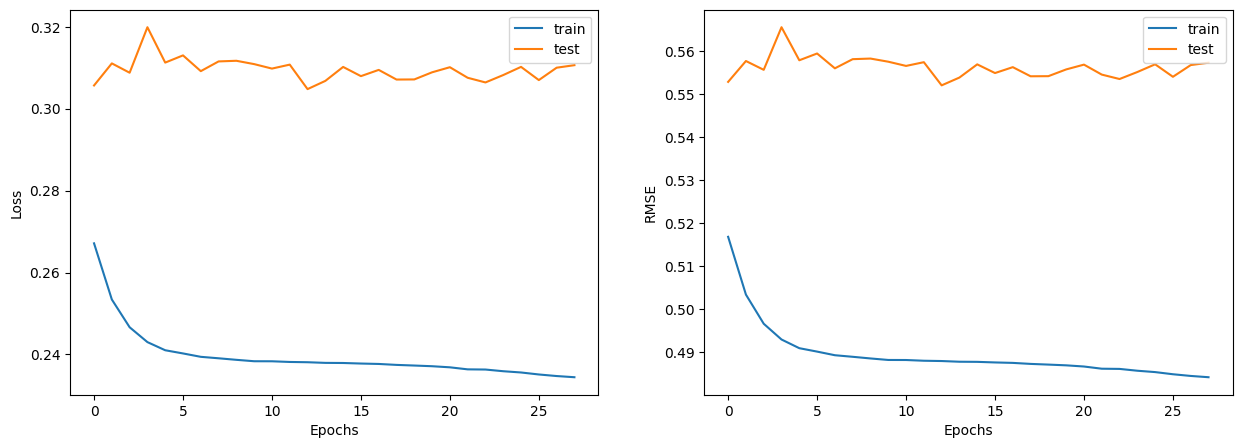

In [514]:
display_learning_curves(history)

This doesn't work well, so manually replacing hidden units to [32,32], optimizer to Nadam, and loss to MSE summed over batch size. Gives this result

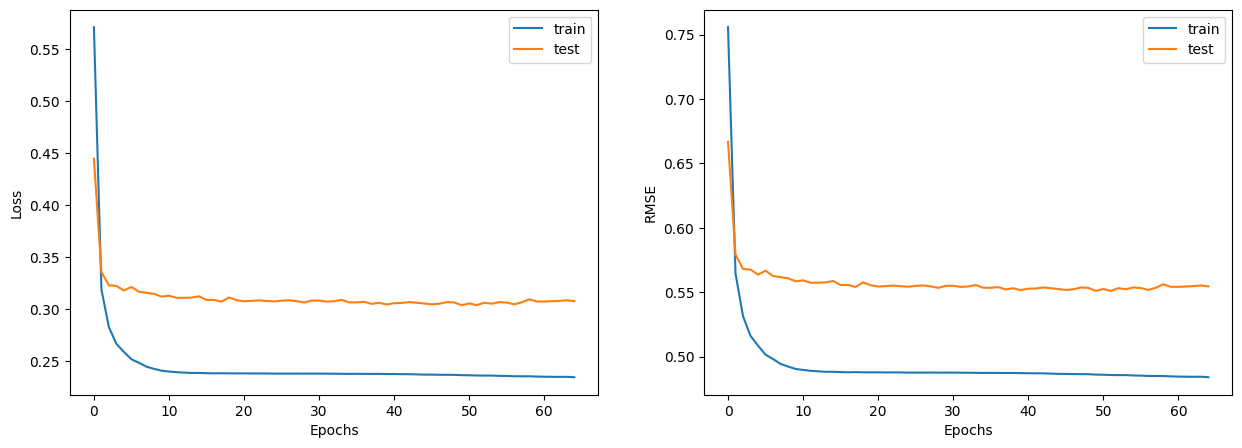

In [ ]:
# display_learning_curves(history)

In [532]:
# save model weights
!mkdir bucket/models/knn_pooling/gnn/

In [533]:
# Save model weights
gnn_model.save_weights('bucket/models/knn_pooling/gnn/model_weights.h5')

# # Later, to load the saved weights...
# # First, recreate the model architecture if it's not already defined
# gnn_model.load_weights('bucket/models/knn_pooling/gnn/model_weights.h5')

# Run on test

In [535]:
test_metadata = pd.read_csv('bucket/test_metadata.csv', index_col = 0)


In [536]:
test_X, test_y_full, test_edge_list = get_X_y(test_metadata, img_loc, pca_loc, top_genes_loc)


Loading data: 100%|██████████| 15/15 [00:40<00:00,  2.71s/it]


In [561]:
test_y_full.reset_index()

,Patient,Replicate,level_2,ENSG00000171345,ENSG00000149273,ENSG00000204628,ENSG00000117984,ENSG00000108518,ENSG00000166441,ENSG00000185624,...,ENSG00000105397,ENSG00000143545,ENSG00000213024,ENSG00000099326,ENSG00000164855,ENSG00000146576,ENSG00000187713,ENSG00000104140,ENSG00000131242,ENSG00000178814
0,BC24220,D2,23x20,3.192728,1.343095,1.841803,3.163238,1.722799,2.044247,1.948140,...,0.0,0.000000,0.000000,0.000000,0.302960,0.00000,0.000000,0.000000,0.302960,0.000000
1,BC24220,D2,23x21,3.604488,1.699344,1.752391,2.938179,1.699344,2.061093,1.982173,...,0.0,0.000000,0.000000,0.000000,0.260843,0.00000,0.260843,0.000000,0.000000,0.000000
2,BC24220,D2,23x22,3.302215,1.844237,1.912040,2.930887,1.607928,1.607928,1.771500,...,0.0,0.367144,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.367144,0.000000
3,BC24220,D2,23x23,3.075035,1.358689,1.459568,2.931703,1.712561,1.635130,1.914298,...,0.0,0.000000,0.345724,0.345724,0.000000,0.00000,0.000000,0.000000,0.806046,0.000000
4,BC24220,D2,23x24,3.183844,1.153516,1.359032,3.153431,1.801997,1.529426,1.674970,...,0.0,0.000000,0.000000,0.000000,0.544128,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6093,BC23209,D1,13x19,0.000000,2.294335,1.979964,1.301649,0.637520,2.665613,1.518886,...,0.0,1.023733,0.000000,0.000000,0.000000,0.63752,0.000000,0.000000,0.000000,0.637520
6094,BC23209,D1,13x17,0.000000,2.368798,2.368798,1.668507,1.668507,2.368798,1.148076,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.730472,0.000000,0.730472,0.000000
6095,BC23209,D1,13x12,0.000000,1.588260,2.432496,1.280049,1.823522,2.432496,1.280049,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,1.280049,0.832217,0.832217,0.000000
6096,BC23209,D1,13x13,0.000000,1.726273,1.546654,1.046570,2.127216,2.010565,2.010565,...,0.0,0.000000,1.046570,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.654372


In [560]:
test_X_ = test_X.reset_index()
test_X_.insert(0, 'node_id',  test_X_["Patient"] + "_" + test_X_["Replicate"] + "_" + test_X_["Index"])
test_X_.drop(columns=["Patient", "Replicate",	"Index"], inplace=True)

In [562]:
test_y_full_ = test_y_full.reset_index()
test_y_full_.insert(0, 'node_id',  test_y_full_["Patient"] + "_" + test_y_full_["Replicate"] + "_" + test_y_full_["level_2"])
test_y_full_.drop(columns=["Patient", "Replicate",	"level_2"], inplace=True)

In [566]:
test_mapper = {node: i for i, node in enumerate(test_X_.node_id)}
test_rev_mapper = {v:k for k,v in test_mapper.items()}

In [567]:
test_X_["node_id"] = test_X_["node_id"].apply(lambda x: test_mapper[x])
test_y_full_["node_id"] = test_y_full_["node_id"].apply(lambda x: test_mapper[x])


In [568]:
x_test = test_X_.node_id.to_numpy()
y_test = test_y_full_.drop(columns=["node_id"]).to_numpy()

In [569]:
_, test_rmse = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)

In [570]:
test_rmse # between validation and train best rmse

0.5440384745597839

In [572]:
test_predictions_df = pd.DataFrame(gnn_model.predict(x_test),
                                    index = test_X_['node_id'].apply(lambda x: test_rev_mapper[x]),
                                    columns = test_y_full_.columns[1:])

191/191 [==============================] - 4s 20ms/step


In [587]:
# save all predictions to file
# train
# Reset the index to make 'index' a column
train_pred = train_predictions_df.reset_index(inplace=False)
train_pred[['Patient', 'Replicate', 'Index']] = train_pred['node_id'].str.split('_', expand=True)
train_pred.drop(columns=['node_id'], inplace=True)
# Reorder the DataFrame columns to have 'Patient', 'Replicate', 'Index' at the beginning
cols = ['Patient', 'Replicate', 'Index'] + [col for col in train_pred.columns if col not in ['Patient', 'Replicate', 'Index']]
train_pred = train_pred[cols]
train_pred.to_csv("bucket/models/knn_pooling/gnn/train_predictions.csv", index = False)


In [588]:
# valid
# Reset the index to make 'index' a column
valid_pred = valid_predictions_df.reset_index(inplace=False)
valid_pred[['Patient', 'Replicate', 'Index']] = valid_pred['node_id'].str.split('_', expand=True)
valid_pred.drop(columns=['node_id'], inplace=True)
# Reorder the DataFrame columns to have 'Patient', 'Replicate', 'Index' at the beginning
cols = ['Patient', 'Replicate', 'Index'] + [col for col in valid_pred.columns if col not in ['Patient', 'Replicate', 'Index']]
valid_pred = valid_pred[cols]
valid_pred.to_csv("bucket/models/knn_pooling/gnn/valid_predictions.csv", index = False)


In [590]:
# test
# Reset the index to make 'index' a column
test_pred = test_predictions_df.reset_index(inplace=False)
test_pred[['Patient', 'Replicate', 'Index']] = test_pred['node_id'].str.split('_', expand=True)
test_pred.drop(columns=['node_id'], inplace=True)
# Reorder the DataFrame columns to have 'Patient', 'Replicate', 'Index' at the beginning
cols = ['Patient', 'Replicate', 'Index'] + [col for col in test_pred.columns if col not in ['Patient', 'Replicate', 'Index']]
test_pred = test_pred[cols]
test_pred.to_csv("bucket/models/knn_pooling/gnn/test_predictions.csv", index = False)


In [599]:
train_y_full.reset_index(inplace=True)
train_y_full.rename(columns={'level_2': 'Index'}, inplace=True)
train_y_full.to_csv("bucket/models/knn_pooling/gnn/train_y.csv", index = False)


In [602]:
test_y_full.reset_index(inplace=True)
test_y_full.rename(columns={'level_2': 'Index'}, inplace=True)
test_y_full.to_csv("bucket/models/knn_pooling/gnn/test_y.csv", index = False)


In [608]:
valid_y_full.reset_index(inplace=True)
valid_y_full.rename(columns={'level_2': 'Index'}, inplace=True)
valid_y_full.to_csv("bucket/models/knn_pooling/gnn/valid_y.csv", index = False)


In [612]:
learning_rate

0.001